# THE LaCE EMULATORS WITH GADGET AND NYX SIMULATIONS

A new version of the LaCE emulators including Nyx simulations is now available in igmhub/LaCE: https://github.com/igmhub/LaCE


In [1]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# load LaCE-related modules
from lace.archive import gadget_archive
from lace.archive import nyx_archive
from lace.emulator.nn_emulator import NNEmulator
from lace.emulator.gp_emulator import GPEmulator
from lace.utils import poly_p1d

## GENERAL USAGE

There are two emulator objects:
- GPEmulator(**args)
- NNEmulator(**args)

And for both, we can call them specifying:
- A custom archive that we have externally generated
- A training set label (training_set), pointing the emulator to a pre-defined training set.

There is also the option of defining a pre-defined emulator with the same configuration as the emulator used in a given publication

## EXAMPLES

### A. HOW TO CREATE AN ARCHIVE

In [ ]:
# Gadget archive with the post-processing using in Pedersen21
mpg_arch_P21 = gadget_archive.GadgetArchive(postproc="Pedersen21")

In the post-processing in Pedersen21, the P1D is measured along one axis, while in Cabayol23, we measure the P1D along the three axes.

In [3]:
# Gadget archive with the post-processing using in Cabayol23
mpg_arch_C23 = gadget_archive.GadgetArchive(postproc="Cabayol23")

In [ ]:
# Nyx archive provided by Solene Chabanier (this function takes a while, so you can limit the z range)
nyx_arch = nyx_archive.NyxArchive(verbose=False)

### B. HOW TO CREATE AN EMULATOR

When calling an emulator, we can choose the settings, or ask for a pre-defined emulator's configuration.
There are three possibilities:

    - Pedersen21: Configuration used in Pedersen21. kmax=3, kbin emulator (available for GP).
    - Pedersen23: Configuration used in Pedersen23. kmax=3, polyfit emulator (available for GP).
    - Cabayol23: Configuration used in Cabayol-Garcia 2023. kmax=4, polyfit emulator (available for NN).

This creates a GP emulator with the default configuration from Pedersen21

In [ ]:
gp_emu_P21 = GPEmulator(archive=mpg_arch_P21,emulator_label='Pedersen21')

Use custom archive provided by the user
Select emulator in Pedersen21
Gaussian Process emulator predicting the P1D at each k-bin. It goes to scales of 3Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones.
Training GP on 330 points


 /home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GPs optimised in 1.20 seconds


This creates a GP emulator with the default configuration from Pedersen23 (same archive, different settings)

In [ ]:
gp_emu_P23 = GPEmulator(archive=mpg_arch_P21,emulator_label='Pedersen23')

Use custom archive provided by the user
Select emulator in Pedersen23
Gaussian Process emulator predicting the P1D, fitting coefficients to a 4th degree polynomial. It goes to scales of 3Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Training GP on 330 points
GPs optimised in 0.38 seconds


This creates a NN emulator with the default configuration of Cabayol23

In [ ]:
nn_emu_C23 = NNEmulator(archive=mpg_arch_C23, emulator_label='Cabayol23')

Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Use custom archive provided by the user
Training samples in archive : 9900
Training NN on 9900 points
NN optimised in 67.61841201782227 seconds


This creates a NN emulator with settings similar to those used in Cabayol23

In [ ]:
fast_training=True
if fast_training:
    print('Using a sub-optimal training for the Nyx emulator, the results will not be as good as possible!')
    # the emulator performance will not be super good here
    nn_emu_nyx = NNEmulator(archive=nyx_arch)
else:
    # this might take a while to train...
    nn_emu_nyx = NNEmulator(archive=nyx_arch, emulator_label='Nyx_v0')

Using a sub-optimal training for the Nyx emulator, the results will not be as good as possible!
Selected custom emulator
Use custom archive provided by the user
Training samples in archive : 4563
Training NN on 4563 points
NN optimised in 32.51673460006714 seconds


### C. POINTING ALSO TO A PRE-DEFINED TRAINING SET

You can also specify the training set instead of passing an archive. If you want to test this, set load_training=True (it will take some time to run)

In [ ]:
load_training=False

In [ ]:
if load_training:
    gp_emu_P21 = GPEmulator(training_set='Pedersen21', emulator_label='Pedersen21')

In [ ]:
if load_training:
    gp_emu_P23 = GPEmulator(training_set='Pedersen21', emulator_label='Pedersen23')

In [ ]:
if load_training:
    nn_emu_C23 = NNEmulator(training_set='Cabayol23', emulator_label='Cabayol23')

In [ ]:
if load_training:
    nn_emu_nyx = NNEmulator(training_set='Nyx23', emulator_label='Nyx_v0')

### TESTING THE EMULATOR

One can also ask the archives for a testing set (a simulation not included in the emulator training)

In [21]:
mpg_test_P21 = mpg_arch_P21.get_testing_data(sim_label='mpg_seed')

In [22]:
mpg_test_C23 = mpg_arch_C23.get_testing_data(sim_label='mpg_seed')

In [29]:
nyx_test = nyx_arch.get_testing_data(sim_label='nyx_3')

In [30]:
def emulator_vs_true(emulator, test_data, iz=0, plot_ratio=True, smooth_test=True):
    
    # get true P1D in test data (over a certain k range)
    k_Mpc = test_data[iz]['k_Mpc']
    test_p1d = test_data[iz]['p1d_Mpc']
    
    # k range used in plot
    mask = (k_Mpc>0) & (k_Mpc<emulator.kmax_Mpc)
    k_Mpc = k_Mpc[mask]
    test_p1d = test_p1d[mask]

    # if smooth_test, use polynomial fit to the test data as truth (as assumed by emulator)
    fit_p1d = poly_p1d.PolyP1D(k_Mpc,test_p1d,deg=emulator.ndeg)
    test_p1d = fit_p1d.P_Mpc(k_Mpc)

    # get emulator parameter values of the test data
    model={}
    for param in emulator.emu_params:
        model[param]=test_data[iz][param]
        print(param,model[param])
    
    # make emulator prediction
    emu_p1d = emulator.emulate_p1d_Mpc(model,k_Mpc)

    if plot_ratio:
        plt.plot(k_Mpc,emu_p1d/test_p1d-1.0)
        plt.plot(k_Mpc,k_Mpc*0.0,ls=':',color='gray')
        plt.ylabel(r'P1D residuals', fontsize = 14)
    else:
        plt.plot(k_Mpc,emu_p1d,label='emulated')
        plt.plot(k_Mpc,test_p1d,label='true')
        plt.legend(fontsize = 14)
        plt.ylabel(r'P1D [Mpc]', fontsize = 14)
    plt.xscale('log')
    plt.xlabel(r'$k$ [1/Mpc]', fontsize = 14)

mF 0.5947010169096263
sigT_Mpc 0.12674038922829378
gamma 1.4991609890700577
kF_Mpc 11.091183861508554
Delta2_p 0.3107109675962955
n_p -2.3000542682795806


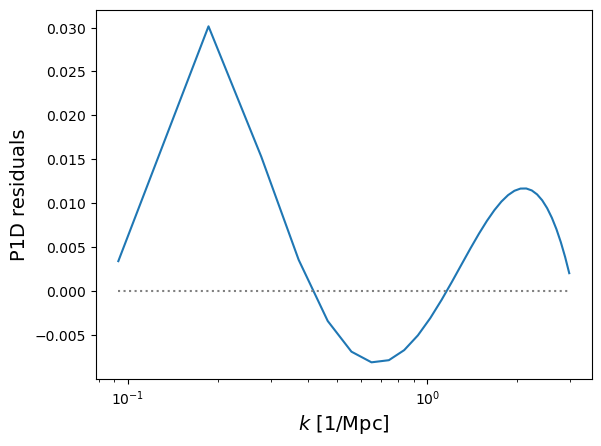

In [31]:
emulator_vs_true(gp_emu_P23,mpg_test_P21,iz=5,plot_ratio=True)

Delta2_p 0.3107109675962955
n_p -2.3000542682795806
mF 0.5947441102855684
sigT_Mpc 0.12674038922829378
gamma 1.4991609890700577
kF_Mpc 11.091183861508554


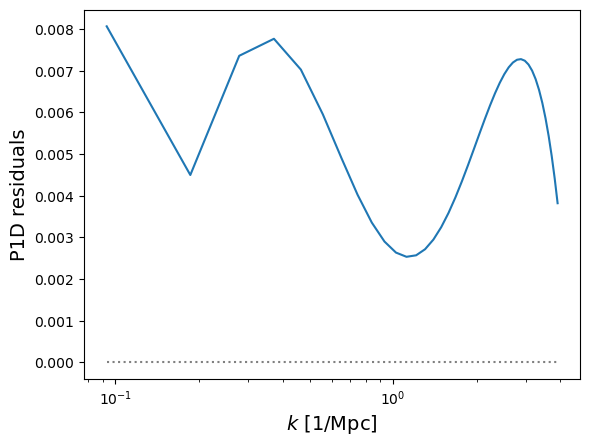

In [32]:
emulator_vs_true(nn_emu_C23,mpg_test_C23,iz=5,plot_ratio=True)

Delta2_p 0.4057780306070093
n_p -2.2570608430894312
mF 0.64014673
sigT_Mpc 0.11261781716106263
gamma 1.5248387
kF_Mpc 14.881301115220772


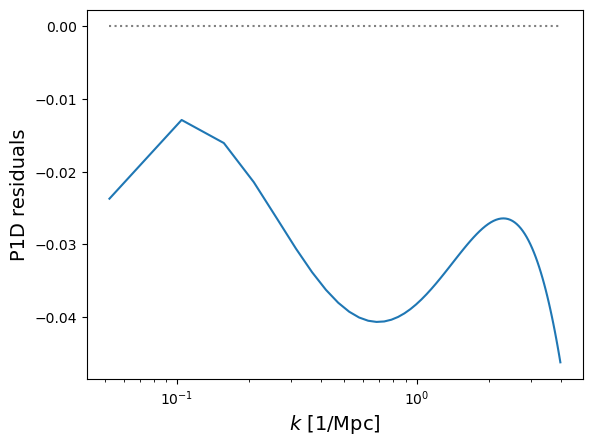

In [33]:
emulator_vs_true(nn_emu_nyx,nyx_test,iz=5,plot_ratio=True)

## D. EXTENDED EMULATOR

In [ ]:
nn_emu_C23 = NNEmulator(archive=mpg_arch_C23, kmax_Mpc=8, ndeg=7)

In [34]:
nn_emu_C23 = NNEmulator(archive=mpg_arch_C23, emulator_label='Cabayol23_extended')

Select emulator in Cabayol23_extended
Neural network emulating the optimal P1D of Nyx simulations fitting coefficients to a 7th degree polynomial. It goes to scales of 8Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones. This configuration does not downweight the contribution of small scales.
Use custom archive provided by the user
Training samples in archive : 9900
Training NN on 9900 points
NN optimised in 66.50159096717834 seconds


Delta2_p 0.3107109675962955
n_p -2.3000542682795806
mF 0.5947441102855684
sigT_Mpc 0.12674038922829378
gamma 1.4991609890700577
kF_Mpc 11.091183861508554


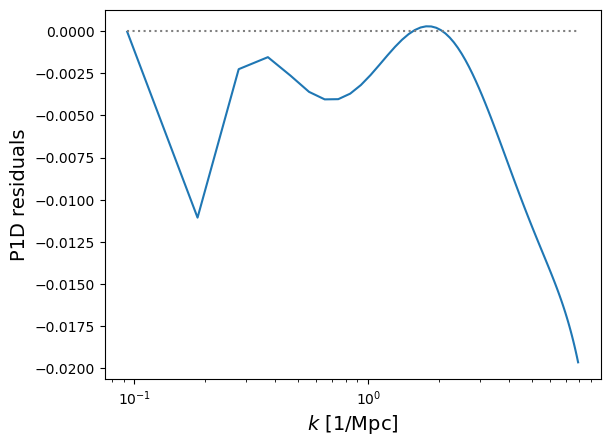

In [35]:
emulator_vs_true(nn_emu_C23,mpg_test_C23,iz=5,plot_ratio=True)

In [ ]:
nn_emu_C23.ndeg